In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [147]:
def sample(signal, trigger: np.ndarray[bool], window_size: int = 256) -> np.ndarray[np.ndarray]:
    """Sample the signal at the points where trigger is True.

    Args:
        signal: The input signal to be sampled.
        trigger: A boolean array indicating where to sample the signal. 
                    Must be the same length as signal.
        window_size: The number of samples to take after each trigger point.
    Returns:
        A numpy array containing the sampled values from the signal.
    """
    n_samples_before = window_size // 2
    n_samples_after = window_size - n_samples_before
    trigger_idxs = np.where(trigger)[0]
    trigger_idxs = trigger_idxs[(trigger_idxs >= n_samples_before) & (trigger_idxs + n_samples_after <= len(signal))]
    sample_idxs = [trigger_idxs[0]]
    for idx in trigger_idxs[1:]:
        if idx - sample_idxs[-1] >= window_size and idx + window_size <= len(signal):
            sample_idxs.append(idx)
    sampled_signal = np.stack([signal[idx - n_samples_before:idx + n_samples_after] for idx in sample_idxs])
    return sampled_signal

def plot_sampled_signal(signal: np.ndarray[np.ndarray], window_size: int) -> None:
    """Plot the sampled signal.

    Args:
        signal: The sampled signal to be plotted.
        window_size: The number of samples in each window.
    """
    num_samples = signal.shape[0]
    time_axis = np.arange(window_size)

    # plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(time_axis, signal[i], alpha=0.5)
    plt.xlabel('Sample Index')
    plt.ylabel('Signal Value')
    plt.title('Sampled Signal')
    plt.grid()
    #plt.show()
   
    
def nco_gen(initial_phase: float = 0,
            lut_size: int        = 2**14,
            phase_acc_width: int = 24) -> Callable[[np.uint32], np.uint16]:

  msk = (2 ** phase_acc_width) - 1
  phase_acc_val = np.uint32(initial_phase * (2 ** phase_acc_width))
  lut = np.uint16((-1 * np.sin(np.linspace(0, 1, lut_size) * 2 * np.pi))  * ((2**15) - 1) + (2**15))

  def nco(step: np.uint32) -> np.uint16:
    nonlocal phase_acc_val

    # next acc value
    phase_acc_val = ((phase_acc_val & msk) + (step & msk)) & msk

    # the index (higher 14 bits) of a waveform lut
    output_idx = (phase_acc_val & msk) >> 10

    return lut[output_idx]

  return nco

def dff_gen()-> Callable[[bool, bool, bool], bool]:
  prev_out: bool = False
  prev_clk: bool = False

  def dff(input: bool, clear :bool, clk: bool) -> bool:
    nonlocal prev_out
    nonlocal prev_clk
    if clk and (not prev_clk):
      output   = 0 if clear else input
      prev_out = output
      prev_clk = clk
      return output

    prev_clk = clk
    prev_out = 0 if clear else prev_out
    return prev_out

  return dff

def lpf1_gen():
  prev_out: np.int16 = 0 # s1q14

  def lpf(input: np.int8) -> np.int16:
    nonlocal prev_out
    # only accept +/-1 (+/- 1/64 under s1q14) or 0 as input
    if input > 0:
      input = 256
    elif input < 0:
      input = -256
    else:
      input = 0

    # (y[n] = 31/32 * y[n-1] + 1/32 x[n])
    if prev_out >= 0:
      output = (prev_out - (prev_out >> 6)) + input
    else:
      prev_out *= -1
      output = input - (prev_out - (prev_out >> 6))

    prev_out = output
    return output
  return lpf

def pfd_gen():
  dff_a = dff_gen()
  dff_b = dff_gen()
  prev_clear: bool = False

  def pfd(a: bool, b: bool) -> np.int16:
    nonlocal dff_a
    nonlocal dff_b
    nonlocal prev_clear

    out_a = dff_a(True, prev_clear, a)
    out_b = dff_b(True, prev_clear, b)

    prev_clear = out_a and out_b

    out_a = 1  if out_a else 0
    out_b = -1 if out_b else 0

    output = out_a + out_b
    return output

  return pfd

def acc_gen():
  acc_val: np.int32 = 0

  def acc(input: np.int8) -> np.int32:
    nonlocal acc_val
    output = acc_val + np.int32(input)
    acc_val = output
    return acc_val
  return acc

def mav_gen(width = 128):
  fifo = [np.int32(0) for i in range(width-1)]
  def mav(input: np.int32):
    nonlocal fifo
    fifo.append(input)
    output = np.sum(fifo) >> 7
    fifo = fifo[1:]
    return output
  return mav

def div2_gen():
  dff = dff_gen()
  n_prev_out: bool = True
  def div2(input: bool) -> bool:
    nonlocal n_prev_out
    output = dff(n_prev_out, False, input)
    n_prev_out = not output
    return output
  return div2

def pll_gen(div2: bool = True):
  base_step = np.uint32(2**20) # base frequency = fs/16
  msk = (2 ** 24) - 1

  ctrl: np.int32 = 0
  nco = nco_gen()
  pfd  = pfd_gen()
  acc  = acc_gen()
  div2 = div2_gen() if div2 else lambda x: x

  def pll(input: np.uint16) -> np.uint16:
    '''
    input 16 bits waveform
    return 14 bits indix of the waveform lut
    '''
    nonlocal ctrl
    nonlocal nco
    nonlocal pfd
    nonlocal acc
    nonlocal div2

    output: np.uint32  = nco(base_step + ctrl)
    output_b: bool     = (output & (2**13)) >> 13
    output_b_div2:bool = div2(output_b)
    input_b : bool     = (input & 2**15) >> 15
    pfd_out: np.int8   = pfd(input_b, output_b_div2)
    acc_out: np.int32  = acc(pfd_out)
    ctrl = (np.int32(pfd_out) << 16) + (acc_out << 10)

    return output

  return pll

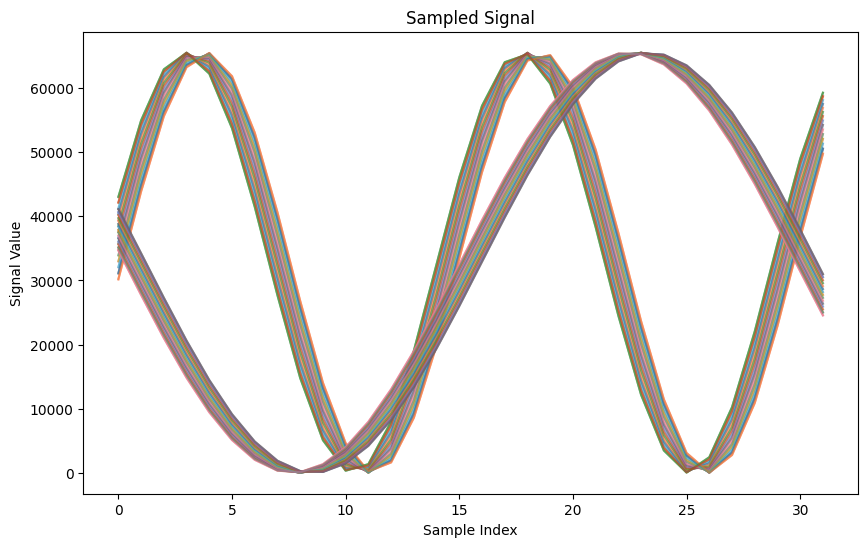

In [150]:
sign = lambda x: (True if x > 32767 else False)

signal_length = 20000
window_size = 32

ref_nco = nco_gen()
pll_nco = nco_gen()
pfd = pfd_gen()
mav = mav_gen()
acc = acc_gen()
div2 = div2_gen()
ref_phase_noise = np.random.randint(-40960, 40960, size=(signal_length,), dtype=np.int32)

ref_signal = np.zeros((signal_length,), dtype=np.uint16)
#ref_signal = np.uint16(np.sin((2 * np.pi + 0.7) * np.arange(signal_length) / 32) * ((2**14) - 1) + (2**15))
pll_signal = np.zeros((signal_length,), dtype=np.uint16)
pfd_signal = np.zeros((signal_length,), dtype=np.int32)


for i in range(signal_length):
    fb_val = 0 if i == 0 else div2((pll_signal[i-1] & (2**15)) >> 15)
    ref_signal[i] = ref_nco(2**19 + 43793)
    pfd_signal[i] = pfd((ref_signal[i] & (2**15)) >> 15, fb_val)
    acc_signal = acc(pfd_signal[i])
    pfd_signal[i] = (np.int32(pfd_signal[i]) << 15)
    ctrl = pfd_signal[i] + (acc_signal << 5)
    pll_signal[i] = pll_nco(2**20 + ctrl)

signs  = np.array([sign(x) for x in ref_signal], dtype=bool)
trigger = np.array([signs[i] != signs[i-1] and signs[i] for i in range(1, len(signs))], dtype=bool) 

plt.figure(figsize=(10, 6))

sampled_signal = sample(pll_signal[-2048:], trigger[-2048:], window_size=window_size)
plot_sampled_signal(sampled_signal, window_size=window_size)
    
sampled_signal = sample(ref_signal[-2048:], trigger[-2048:], window_size=window_size)
plot_sampled_signal(sampled_signal, window_size=window_size)